# Code Appendix: Stage 1

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
path = ('C:/Users/Ong Jia Yi/Desktop/STUDY/4b. Fall 2020 - Winter 2021/'
        'Winter - ECO421H (Macroeconomic Finance)/Assignments/Project/Data/'
        'clustering_dataset.csv')
data = pd.read_csv(path, encoding = "ISO-8859-1")

In [3]:
data.shape

(189, 19)

In [4]:
data.columns

Index(['country', 'HDI', 'life_exp_at_birth', 'exp_years_of_schl',
       'mean_years_of_schl', 'GNI_pc', 'labour_part_F', 'labour_part_M',
       'urban_perc', 'employ_agri_perc', 'employ_service_perc', 'exp_imp_perc',
       'FDI_net_perc', 'remitt_flow_perc', 'net_migration',
       'immigrant_stock_perc', 'int_inbound_tourist', 'internet_users_perc',
       'mobile_subscriptions'],
      dtype='object')

In [5]:
data_cleaned = data.dropna(axis=0)
data_cleaned =data_cleaned.drop(data_cleaned[
    data_cleaned.country.isin(["Oman", "Lebanon", "Algeria", 'Azerbaijan', 'Suriname', 'Iran (Islamic Republic of)',
                               "Saint Vincent and the Grenadines", 'North Macedonia', 'Ecuador', 'Dominican Republic',
                               "Georgia"
                              ])].index)
data_cleaned.shape

(143, 19)

In [6]:
# subset data based on top percentile of GNI_pc
data_cleaned = data_cleaned.sort_values(['GNI_pc'], ascending = False)
n = math.floor(data_cleaned.shape[0]*0.55)
data_cleaned = data_cleaned.head(n)

# reset index
data_cleaned.reset_index(inplace=True)
data_cleaned = data_cleaned.drop(["index"], axis=1)

In [7]:
data_cleaned.shape

(78, 19)

## PCA

In [8]:
standardized = StandardScaler().fit_transform(data_cleaned.drop(["country"], axis=1))

In [38]:
pca = PCA(n_components=standardized.shape[1])
principalComponents = pca.fit_transform(standardized)

index = pd.Index(data_cleaned.index.values.tolist())
PCA_components = pd.DataFrame(principalComponents, index=index)
PCA_components.set_index = data_cleaned.index.values

index = data_cleaned.drop(["country"], axis=1).columns
loadings = pd.DataFrame(pca.components_[:2].T, columns=['PC1', 'PC2'], index=index )

<function matplotlib.pyplot.show(close=None, block=None)>

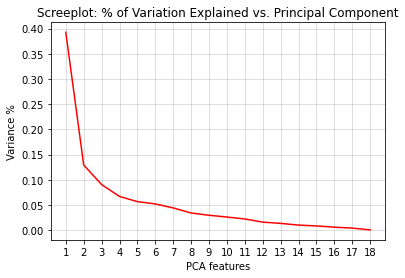

In [107]:
features = range(1, pca.n_components_+1)
plot_data = pd.DataFrame(pca.explained_variance_ratio_,
                         index=features)
plt.plot(plot_data, color='red')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.title('Screeplot: % of Variation Explained vs. Principal Component')
plt.xticks(features)
plt.grid(alpha=0.5)
plt.savefig('stage_1 - PCA_screeplot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

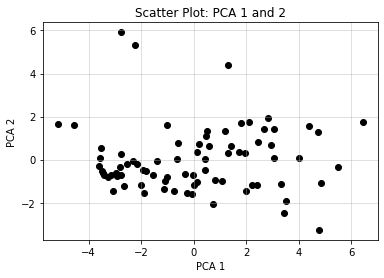

In [108]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=1, 
            color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter Plot: PCA 1 and 2')
plt.grid(alpha=0.5)
plt.savefig('stage_1 - PCA scatter.png')
plt.show

In [58]:
loadings

,PC1,PC2
HDI,-0.350079,-0.195851
life_exp_at_birth,-0.296319,-0.105218
exp_years_of_schl,-0.269180,-0.227864
mean_years_of_schl,-0.256055,-0.334619
GNI_pc,-0.331763,0.071086
labour_part_F,-0.163522,0.063037
labour_part_M,0.022759,0.552457
urban_perc,-0.255842,0.144823
employ_agri_perc,0.314862,0.019593
employ_service_perc,-0.308940,-0.032008


## K-Means

### Tune Hyperparameter

In [80]:
num_pc = 2
PC_data = PCA_components.iloc[:,:num_pc]

In [81]:
K = 15
totwss_list = []
for k in range(1,K+1):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=5, random_state=0)
    fit = kmeans.fit(PC_data)
    totwss = fit.inertia_
    totwss_list.append(totwss)

<function matplotlib.pyplot.show(close=None, block=None)>

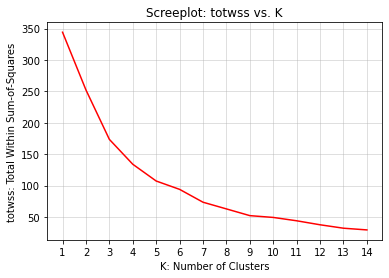

In [109]:
plot_data = pd.DataFrame(totwss_list)
plot_data = pd.DataFrame(plot_data, index=range(1,15))
plt.plot(plot_data, alpha=1, color="red")
plt.xlabel('K: Number of Clusters')
plt.ylabel('totwss: Total Within Sum-of-Squares')
plt.title('Screeplot: totwss vs. K')
plt.xticks(range(1,15))
plt.grid(alpha=0.5)
plt.savefig('stage_1 - K_screeplot.png')
plt.show

### Fit Final Model

In [96]:
K = 4
kmeans = KMeans(init="k-means++", n_clusters=K, n_init=5, random_state=0)
fit = kmeans.fit(PC_data)

<function matplotlib.pyplot.show(close=None, block=None)>

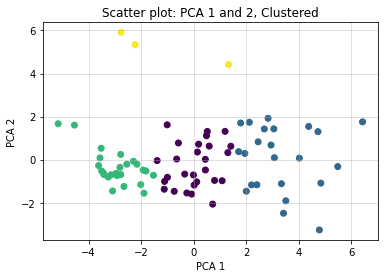

In [111]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=1, c=fit.labels_)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("Scatter plot: PCA 1 and 2, Clustered")
plt.grid(alpha=0.5)
plt.savefig('stage_1 - K_scatter.png')
plt.show

In [796]:
# see countries by cluster
data_cleaned.loc[np.where(fit.labels_ == 4)[0].tolist(),"country"]

Series([], Name: country, dtype: object)

### Define function to extract country closest to cluster center

In [797]:
def closest(data, center, n):
    """Return the indexes of the n closest datapoints
    to the center of the cluster they are in.
    
    Precondition: n <= data.shape[0]
    
    Input:
    -  data: a pandas dataframe of the coordinates of 
             every datapoint in the same cluster
    -  center: a numpy array of the center coordinates
    -  n: an integer
    Output:
    -  a dictionary containing an array of the indexes of the 
       n closest datapoints and their distances
    """
    def euclidean(point, center):
        dist = np.linalg.norm(point - center)
        return dist

    distances = np.apply_along_axis(euclidean, 1, data, center)
    distances = pd.DataFrame(distances)
    distances = distances.sort_values(distances.columns[0], ascending=True)
    
    dists = distances.head(n)
    indexes = dists.index.values
    
    return {"indexes": data.index.values[indexes], "dists": dists[0].tolist()}

In [802]:
# displaying n closest countries to each cluster center
# and their respective distances
n = 6
for i in range(K):
    subdata = PC_data.iloc[fit.labels_ == i,:]
    center = fit.cluster_centers_[i]
    out = closest(subdata, center, n)
    printout = [j + ": " + str(round(k, 2)) for j,k in 
                zip(data_cleaned.loc[out["indexes"], "country"], out["dists"])]
    print(printout)

['Slovakia: 0.45', 'Barbados: 0.46', 'Belarus: 0.49', 'Portugal: 0.56', 'Russian Federation: 0.63', 'Argentina: 0.75']
['Tunisia: 0.24', 'Mongolia: 0.71', 'China: 0.73', 'South Africa: 1.16', 'Armenia: 1.17', 'Mexico: 1.38']
['Canada: 0.13', 'Germany: 0.26', 'United States: 0.35', 'United Kingdom: 0.36', 'Ireland: 0.39', 'Israel: 0.42']
['Kuwait: 1.01', 'Qatar: 1.69', 'Maldives: 2.67']
